In [22]:
import os
import glob
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dropout
from keras import backend as K

np.set_printoptions(suppress=True)

In [4]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

### Info:
- Only gansystems and Panasonic folder need to be used. 
- c1 is the gate voltage, c2- output voltage and c3- current.
- Trying to find f such that f(c1, c2, time) = c3

## Reading all data

In [5]:
# Collecting all file names
base_dir = '../Nikki/Experimental Results'

def get_files_of_name(filename, directory):
    return [file for file in glob.glob('{}/{}/**/{}'.format(base_dir, directory, filename), recursive=True)]

c1_files = get_files_of_name('C1.txt', 'GaNSystemsGS6650') + get_files_of_name('C1.txt', 'PanasonicGaN')
c2_files = get_files_of_name('C2.txt', 'GaNSystemsGS6650') + get_files_of_name('C2.txt', 'PanasonicGaN')
c3_files = get_files_of_name('C3.txt', 'GaNSystemsGS6650') + get_files_of_name('C3.txt', 'PanasonicGaN')
print('Total c1, c2, c3 files:', len(c1_files), len(c2_files), len(c3_files))

Total c1, c2, c3 files: 21 21 21


In [6]:
# Reading data in all files
def read_files(files):
    x_all, y_all = [], []
    for file in files:
        x,y = [],[]
        for line in open(file, 'r'):
            words = [float(a) for a in line.strip().split(',')]
            x.append(words[0] * 1e09)
            y.append(words[1])
        x_all.append(x)
        y_all.append(y)
    return x_all, y_all

time_c1_list, c1_list = read_files(c1_files)
time_c2_list, c2_list = read_files(c2_files)
time_c3_list, c3_list = read_files(c3_files)

### Plotting read data

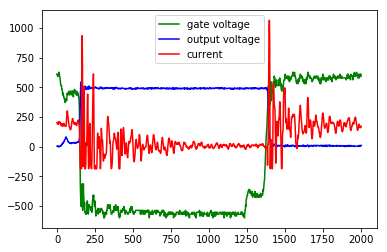

In [7]:
exp_id = 2
plt.plot(time_c1_list[exp_id], 100*np.array(c1_list[exp_id]), c='g', label='gate voltage')
plt.plot(time_c2_list[exp_id], c2_list[exp_id], c='b', label='output voltage')
plt.plot(time_c3_list[exp_id], c3_list[exp_id], c='r', label='current')
plt.legend()

In [8]:
## check if number of recordings are the same across c1, c2, c3 for all experiments
for c1, c2, c3 in zip(c1_list, c2_list, c3_list):
    assert len(c1) == len(c2) == len(c3)

### Split data to train/val/test by exps

In [9]:
TRAIN_SPLIT = 0.9
num_train_exps = int(len(c1_list) * TRAIN_SPLIT)
num_train_exps
train_c1_list, train_c2_list, train_c3_list = c1_list[:num_train_exps], c2_list[:num_train_exps], c3_list[:num_train_exps]
test_c1_list, test_c2_list, test_c3_list = c1_list[num_train_exps:], c2_list[num_train_exps:], c3_list[num_train_exps:]
print(len(train_c1_list), len(train_c2_list), len(train_c3_list))
print(len(test_c1_list), len(test_c2_list), len(test_c3_list))

18 18 18
3 3 3


### Generating inputs, outputs for training

In [11]:
### Inputs should be generated of the form (batch_size, timesteps, input_dim)
## timesteps can vary
def generate_inputs(c1_list, c2_list):
    return [[[c1, c2] for c1, c2 in zip(c1s, c2s)] for c1s, c2s in zip(c1_list, c2_list)]

train_list = generate_inputs(train_c1_list, train_c2_list)
test_list = generate_inputs(test_c1_list, test_c2_list)

In [12]:
def get_stats(_2ddata):
    def flatten(_2dlist):
        return [element for _1dlist in _2dlist for element in _1dlist]
    
    flat_data = np.array(flatten(_2ddata))
    return np.mean(flat_data, axis=0), np.std(flat_data, axis=0)

x_mean, x_std = get_stats(train_list)
y_mean, y_std = get_stats(train_c3_list)
print(x_mean, x_std)
print(y_mean, y_std)

[  -0.97428942  306.67446456] [   5.45338372  234.83153876]
83.475447065 155.760585796


In [13]:
## Normalize data
def z_score_data(_2dlist, mean, std):
    return [np.stack([(x - mean) / std for x in _1dlist]) for _1dlist in _2dlist]

X_train = z_score_data(train_list, x_mean, x_std)
X_test = z_score_data(test_list, x_mean, x_std)

Y_train = z_score_data(train_c3_list, y_mean, y_std)
Y_test = z_score_data(test_c3_list, y_mean, y_std)

In [14]:
max_time_sequence = max([_x.shape[0] for _x in X_train] + [_x.shape[0] for _x in Y_train])
max_time_sequence

1002

In [15]:
from keras.preprocessing import sequence

print('Pad sequences (samples x time)')
X_train = np.array(sequence.pad_sequences(X_train, maxlen=max_time_sequence, dtype=np.float64))
X_test = np.array(sequence.pad_sequences(X_test, maxlen=max_time_sequence, dtype=np.float64))

Y_train = np.expand_dims(np.array(sequence.pad_sequences(Y_train, maxlen=max_time_sequence, dtype=np.float64)), axis=-1)
Y_test = np.expand_dims(np.array(sequence.pad_sequences(Y_test, maxlen=max_time_sequence, dtype=np.float64)), axis=-1)

Pad sequences (samples x time)


In [16]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((18, 1002, 2), (18, 1002, 1), (3, 1002, 2), (3, 1002, 1))

## Model 1

In [24]:
## Model def
# input : (batch_size, timesteps, input_dim)
model = Sequential()
model.add(GRU(64, return_sequences=True, input_shape=(max_time_sequence, 2)))
model.add(Dense(1, kernel_initializer='normal'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 1002, 64)          12864     
_________________________________________________________________
dense_2 (Dense)              (None, 1002, 1)           65        
Total params: 12,929
Trainable params: 12,929
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [26]:
time = datetime.now().strftime('%Y%m%d%H%M')
model_saver = ModelCheckpoint(filepath="models/gan-{}-".format(time) + "epoch_{epoch:02d}-val_loss_{val_loss:.2f}.h5", 
                              monitor='val_loss', save_best_only=True)

history = model.fit(X_train, Y_train, 
                    batch_size=4,
                    epochs=500, 
                    validation_data=(X_test, Y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5), model_saver])

Train on 18 samples, validate on 3 samples
Epoch 1/500
18/18 [==============================] - 3s - loss: 0.4639 - val_loss: 0.4485
Epoch 2/500
18/18 [==============================] - 3s - loss: 0.4257 - val_loss: 0.4193
Epoch 3/500
18/18 [==============================] - 3s - loss: 0.3878 - val_loss: 0.3951
Epoch 4/500
18/18 [==============================] - 3s - loss: 0.3608 - val_loss: 0.3835
Epoch 5/500
18/18 [==============================] - 3s - loss: 0.3542 - val_loss: 0.3811
Epoch 6/500
18/18 [==============================] - 3s - loss: 0.3565 - val_loss: 0.3730
Epoch 7/500
18/18 [==============================] - 3s - loss: 0.3518 - val_loss: 0.3680
Epoch 8/500
18/18 [==============================] - 3s - loss: 0.3490 - val_loss: 0.3637
Epoch 9/500
18/18 [==============================] - 3s - loss: 0.3484 - val_loss: 0.3565
Epoch 10/500
18/18 [==============================] - 3s - loss: 0.3470 - val_loss: 0.3477
Epoch 11/500
18/18 [==============================] - 3s

In [27]:
Y_test_pred = model.predict(X_test)

In [37]:
def plot_exp(X, Y, Y_pred):
    c1 = X[:, 0]
    c2 = X[:, 1]
    plt.figure()
    plt.plot(range(len(c1)), 10*c1, c='g', label='gate voltage')
    plt.plot(range(len(c1)), c2, c='b', label='output voltage')
    plt.plot(range(len(c1)), Y, c='r', label='current')
    plt.plot(range(len(c1)), Y_pred, c='k', label='pred current')
    plt.legend()

def plot_with_pred(X, Y, Y_pred):
    _x = (X * x_std) + x_mean
    _y = (Y * y_std) + y_mean
    _y_pred = (Y_pred * y_std) + y_mean
    plot_exp(_x, _y, _y_pred)    

### Plotting prediction on test data

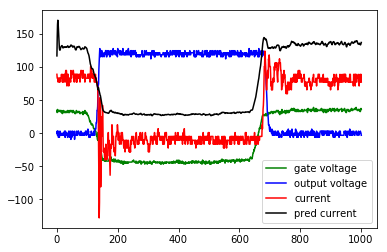

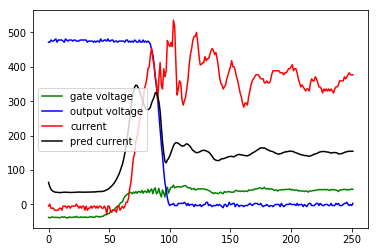

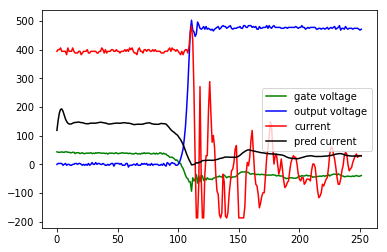

In [41]:
for exp_id in range(len(test_c3_list)):
    exp_length = len(test_c3_list[exp_id])
    plot_with_pred(X_test[exp_id][-exp_length:], Y_test[exp_id][-exp_length:], Y_test_pred[exp_id][-exp_length:])

### Plotting prediction on train data

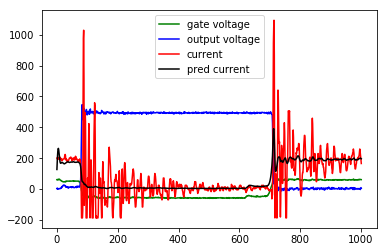

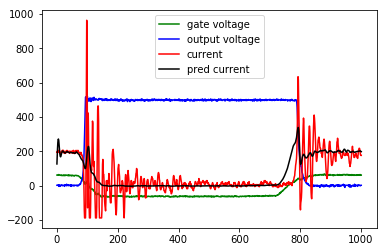

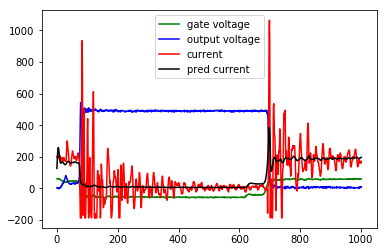

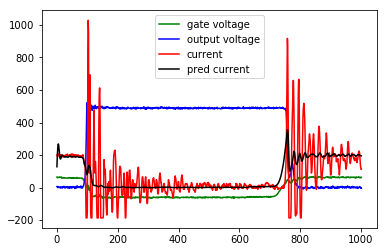

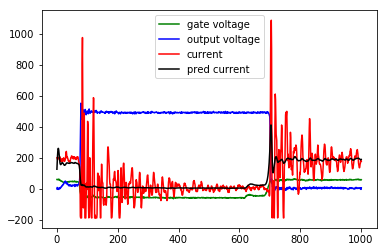

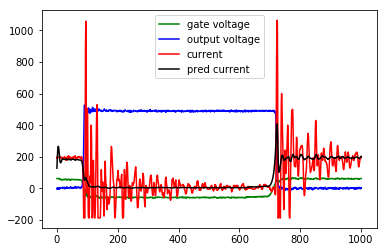

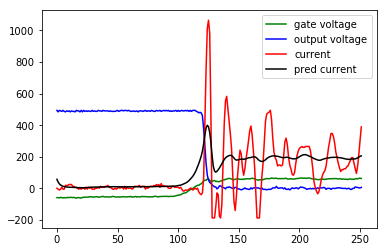

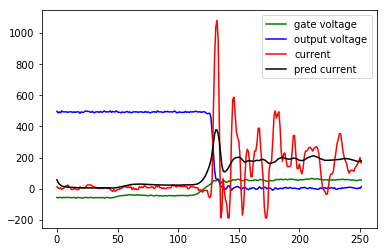

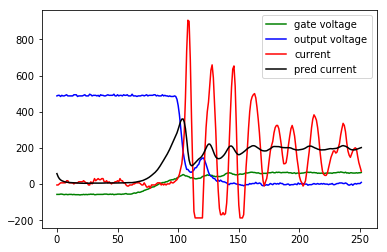

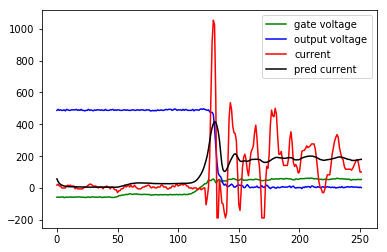

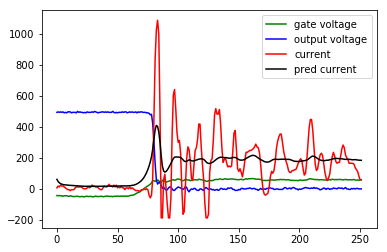

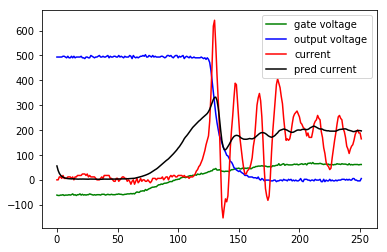

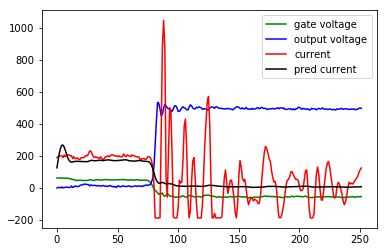

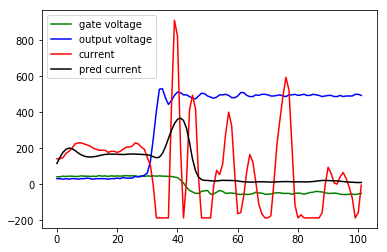

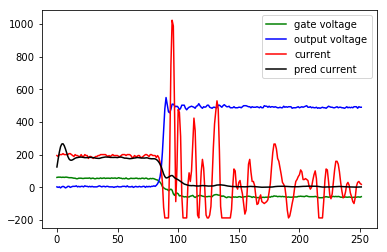

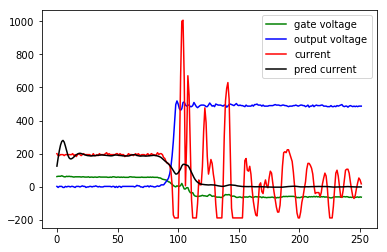

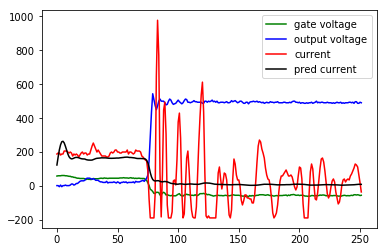

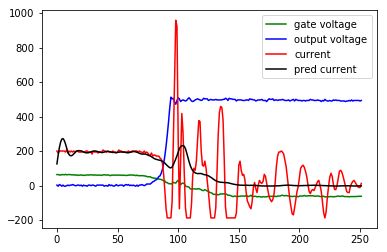

In [42]:
Y_train_pred = model.predict(X_train)

for exp_id in range(len(train_c3_list)):
    exp_length = len(train_c3_list[exp_id])
    plot_with_pred(X_train[exp_id][-exp_length:], Y_train[exp_id][-exp_length:], Y_train_pred[exp_id][-exp_length:])

## Model 2

In [65]:
## Model def
# input : (batch_size, timesteps, input_dim)
model = Sequential()
# model.add(GRU(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(max_time_sequence, 2)))
# model.add(GRU(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model.add(GRU(64, return_sequences=True, input_shape=(max_time_sequence, 2)))
model.add(GRU(32, return_sequences=True))
model.add(Dense(1, kernel_initializer='normal'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_5 (GRU)                  (None, 1002, 64)          12864     
_________________________________________________________________
gru_6 (GRU)                  (None, 1002, 32)          9312      
_________________________________________________________________
dense_4 (Dense)              (None, 1002, 1)           33        
Total params: 22,209
Trainable params: 22,209
Non-trainable params: 0
_________________________________________________________________


In [66]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [67]:
time = datetime.now().strftime('%Y%m%d%H%M')
model_saver = ModelCheckpoint(filepath="models/gan-{}-".format(time) + "epoch_{epoch:02d}-val_loss_{val_loss:.2f}.h5", 
                              monitor='val_loss', save_best_only=True)

history = model.fit(X_train, Y_train, 
                    batch_size=4,
                    epochs=500, 
                    validation_data=(X_test, Y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5), model_saver])

Train on 18 samples, validate on 3 samples
Epoch 1/500
18/18 [==============================] - 8s - loss: 0.4568 - val_loss: 0.4275
Epoch 2/500
18/18 [==============================] - 7s - loss: 0.4105 - val_loss: 0.3905
Epoch 3/500
18/18 [==============================] - 7s - loss: 0.3722 - val_loss: 0.3555
Epoch 4/500
18/18 [==============================] - 7s - loss: 0.3527 - val_loss: 0.3348
Epoch 5/500
18/18 [==============================] - 6s - loss: 0.3557 - val_loss: 0.3293
Epoch 6/500
18/18 [==============================] - 7s - loss: 0.3522 - val_loss: 0.3262
Epoch 7/500
18/18 [==============================] - 7s - loss: 0.3469 - val_loss: 0.3277
Epoch 8/500
18/18 [==============================] - 7s - loss: 0.3468 - val_loss: 0.3235
Epoch 9/500
18/18 [==============================] - 7s - loss: 0.3456 - val_loss: 0.3120
Epoch 10/500
18/18 [==============================] - 7s - loss: 0.3436 - val_loss: 0.2995
Epoch 11/500
18/18 [==============================] - 7s

In [68]:
Y_test_pred = model.predict(X_test)

In [69]:
def plot_exp(X, Y, Y_pred):
    c1 = X[:, 0]
    c2 = X[:, 1]
    plt.figure()
    plt.plot(range(len(c1)), 10*c1, c='g', label='gate voltage')
    plt.plot(range(len(c1)), c2, c='b', label='output voltage')
    plt.plot(range(len(c1)), Y, c='r', label='current')
    plt.plot(range(len(c1)), Y_pred, c='k', label='pred current')
    plt.legend()

def plot_with_pred(X, Y, Y_pred):
    _x = (X * x_std) + x_mean
    _y = (Y * y_std) + y_mean
    _y_pred = (Y_pred * y_std) + y_mean
    plot_exp(_x, _y, _y_pred)    

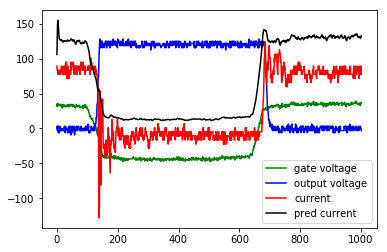

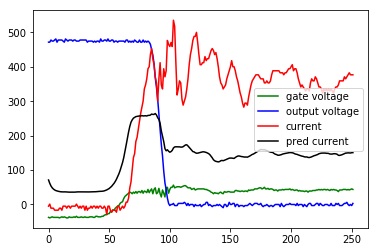

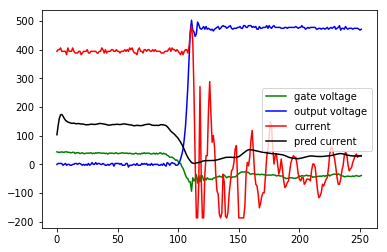

In [70]:
for exp_id in range(len(test_c3_list)):
    exp_length = len(test_c3_list[exp_id])
    plot_with_pred(X_test[exp_id][-exp_length:], Y_test[exp_id][-exp_length:], Y_test_pred[exp_id][-exp_length:])

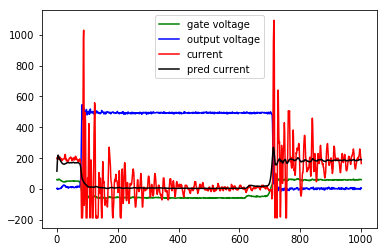

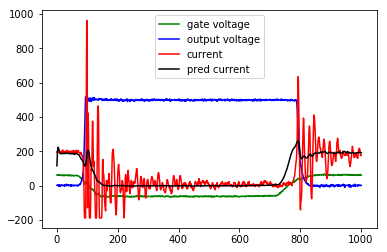

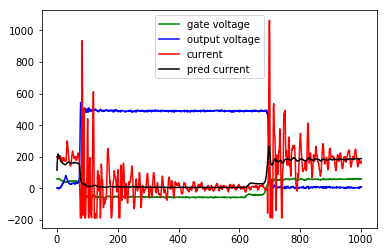

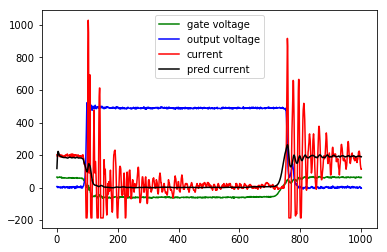

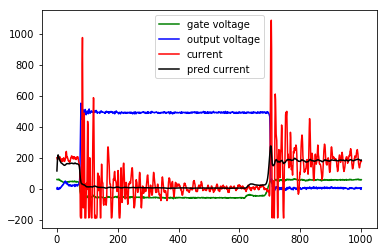

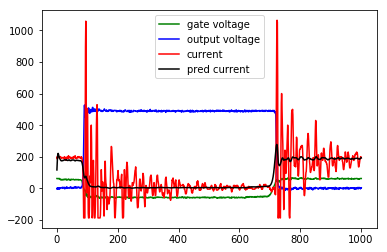

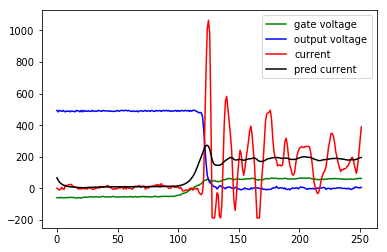

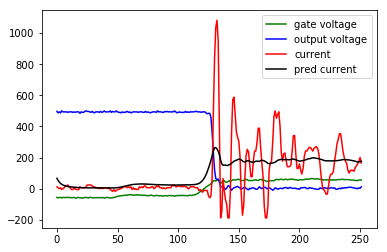

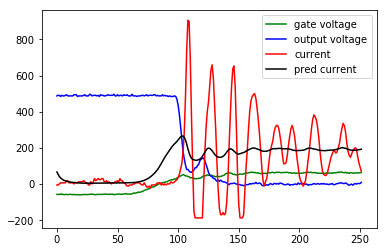

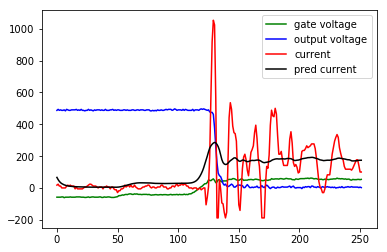

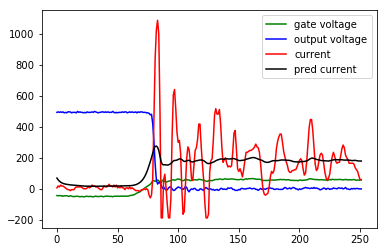

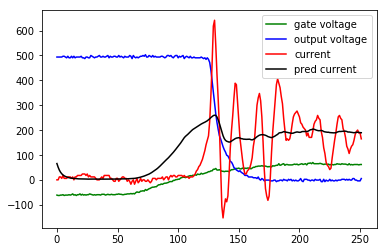

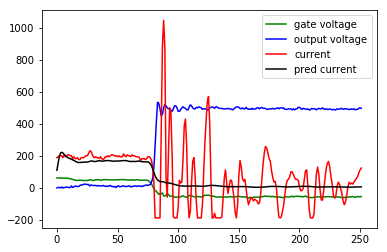

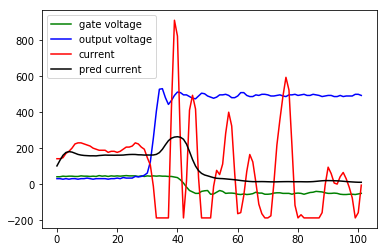

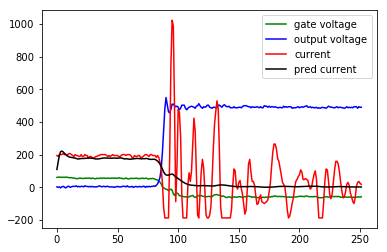

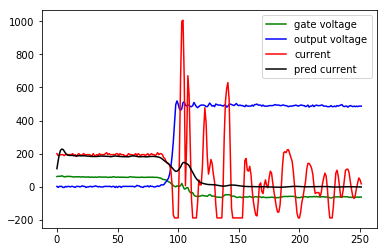

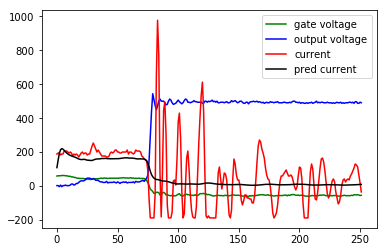

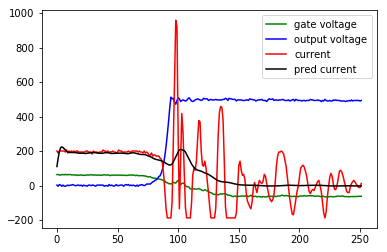

In [71]:
Y_train_pred = model.predict(X_train)

for exp_id in range(len(train_c3_list)):
    exp_length = len(train_c3_list[exp_id])
    plot_with_pred(X_train[exp_id][-exp_length:], Y_train[exp_id][-exp_length:], Y_train_pred[exp_id][-exp_length:])

### kids work?
 - why do they have 5 inputs?

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from decimal import Decimal
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from matplotlib.ticker import FixedFormatter

def normalise(data):
    data=[float(x) for x in data]
    data = [(x/max(data)) for x in data]
    return data

df_gate=pd.read_csv('../Nikki/Experimental Results/GaNSystemsGS6650/off/400V_gd0.5Vpp_off/C1.txt', delimiter=',',header=None)
df1=pd.read_csv('../Nikki/Experimental Results/GaNSystemsGS6650/off/400V_gd0.5Vpp_off/C2.txt', delimiter=',',header=None)
df2=pd.read_csv('../Nikki/Experimental Results/GaNSystemsGS6650/off/400V_gd0.5Vpp_off/C3.txt',delimiter=',', header=None)

In [55]:
df2 = df2.drop(df2.columns[[0]], axis=1)
df1 = pd.concat([df1, df2], axis=1)
df1.columns=['Time', 'C2', 'C3']
df1['Voltage'] = 400
df1['Vpp'] = 2
df1['On'] = 1

df1 = pd.concat([df1, df_gate], axis=1)
df1 = df1.rename(columns={1: 'C1'})
df_gate = df_gate.drop(df_gate.columns[[0]], axis=1)

In [56]:
df1.head()

,Time,C2,C3,Voltage,Vpp,On,0,C1
0,-8.880000e-10,3.12497,200.750,400,2,1,-3.780000e-10,6.25625
1,1.112000e-09,-3.12503,189.000,400,2,1,1.622000e-09,6.41563
2,3.112000e-09,3.12497,189.000,400,2,1,3.622000e-09,6.41563
3,5.112000e-09,3.12497,194.875,400,2,1,5.622000e-09,6.41563
4,7.112000e-09,3.12497,194.875,400,2,1,7.622000e-09,6.73438


In [57]:
# C1
df_gate.head()

,1
0,6.25625
1,6.41563
2,6.41563
3,6.41563
4,6.73438
